In [198]:
import os
import tensorflow as tf
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from keras.utils import to_categorical
import cv2
import imghdr # 可根據文件的內容推測其類型
import matplotlib.pyplot as plt
import numpy as np

# 資料預處理

In [1]:
data_dir = 'data'

In [2]:
# Image extension
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [6]:
os.listdir(data_dir)
# for image_class in os.listdir(data_dir):
#     print(image_class)
    # for image in os.listdir(os.path.join(data_dir, image_class)):
    #     print(image)

['cat', 'dog']

In [8]:
img = cv2.imread(os.path.join(data_dir, 'cat', '1200px-RedCat_8727.jpg'))
img.shape # (height, width, RGB)

(800, 1200, 3)

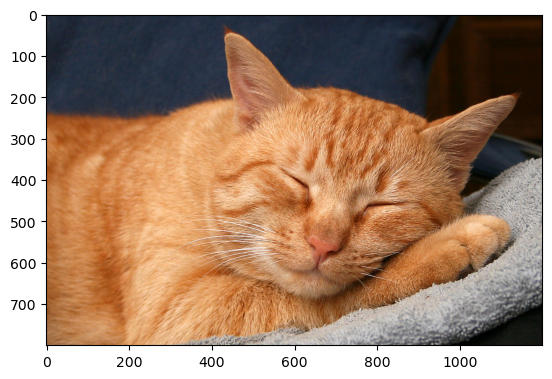

In [11]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [12]:
# 過濾圖片
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extension {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Error with image {}'.format(image_path))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


# 載入資料

In [150]:
image_size = (256, 256)
batch_size = 32

In [151]:
# data = tf.keras.utils.image_dataset_from_directory('data')
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical',  # 設定 label 微熱編碼
    shuffle=True,  # 隨機打亂
    seed=42 
)
print(data.element_spec)

Found 534 files belonging to 2 classes.
(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))


In [175]:
data_iterator = data.as_numpy_iterator()

In [176]:
# 取得下一批
# batch[0]圖片資料(numpy array)、batch[1]資料標籤
batch = data_iterator.next()

In [177]:
print(len(batch))
print(batch[0].shape) # (每批圖片數, height, width, RGB)
print(batch[1]) # lable

2
(32, 256, 256, 3)
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


2023-09-22 21:21:28.660283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 21:21:28.852084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


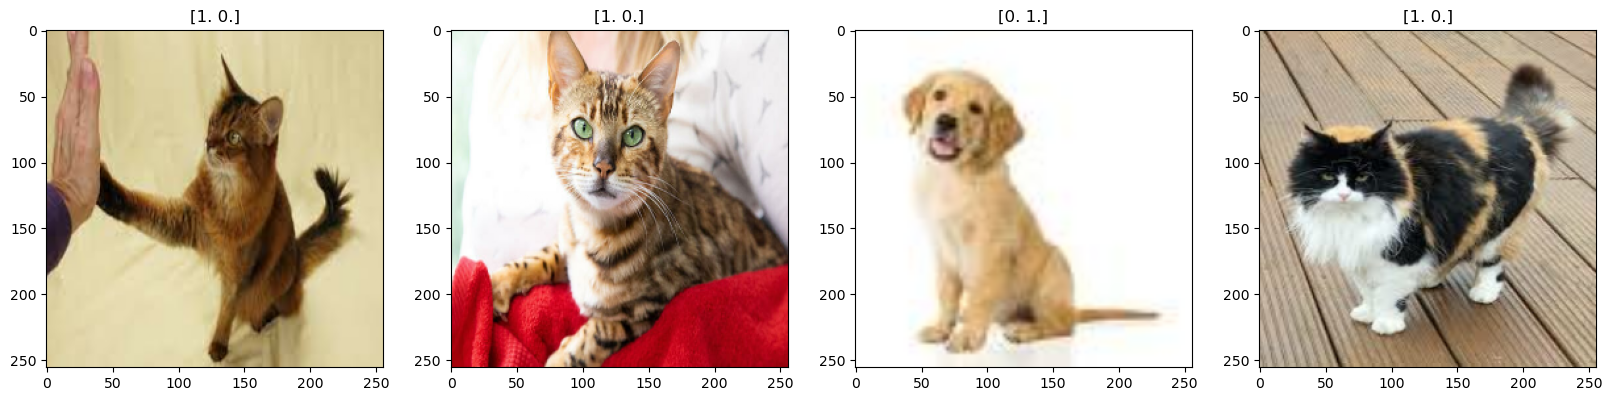

In [185]:
# 查看圖片，標籤對應
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    # ax[idx].imshow(img.astype(int))
    ax[idx].imshow(img)
    ax[idx].title.set_text(str(batch[1][idx]))

In [157]:
# x圖片，y標籤
data = data.map(lambda x, y : (x / 255, y))

In [158]:
batch = data.as_numpy_iterator().next()

In [159]:
len(data)

17

In [160]:
# 訓練大小
train_size = int(len(data) * .8)
# 驗證大小
val_size = int(len(data) * .1) + 1 
# 測試大小
test_size = int(len(data) * .1) + 1

train_size, val_size, test_size

(13, 2, 2)

In [161]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

len(train), len(val), len(test)

(13, 2, 2)

# U-Net架構圖

![U-Net](https://pica.zhimg.com/v2-1af1f45d24e8ae6d9f9a6af672699d3f_720w.jpg?source=172ae18b)

In [162]:
# 定义U-Net模型
def unet_model(input_shape):
    model = Sequential()

    # 編碼器（下採樣路徑）
    model.add(Input(shape=input_shape))
    model.add(Conv2D(64, 3, activation='relu', padding='same'))
    model.add(Conv2D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 中間層
    model.add(Conv2D(128, 3, activation='relu', padding='same'))
    model.add(Conv2D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # 解碼器（上採樣路徑）
    model.add(Conv2D(64, 3, activation='relu', padding='same'))
    model.add(Conv2D(64, 3, activation='relu', padding='same'))
    model.add(UpSampling2D(size=(2, 2)))

    # 輸出層
    # model.add(Conv2D(2, 1, activation='softmax'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    return model

In [163]:
# 建立 U-Net 模型
input_shape = (256, 256, 3)
model = unet_model(input_shape)
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_75 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_77 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                               

In [132]:
logs_dir = 'logs'

In [133]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logs_dir)

In [134]:
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [135]:
model_checkpoint_callback = ModelCheckpoint(
    filepath='./models/cat_dog_classification.h5',  
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [164]:
history = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping_callback, model_checkpoint_callback]
)

Epoch 1/30


2023-09-22 00:18:01.322872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:18:01.530754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 1.7152 - accuracy: 0.5192

2023-09-22 00:18:56.512984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:18:56.701359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 1: val_loss improved from inf to 0.88195, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 61s 5s/step - loss: 1.7152 - accuracy: 0.5192 - val_loss: 0.8819 - val_accuracy: 0.5312
Epoch 2/30


2023-09-22 00:19:01.584823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:19:01.860810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.7271 - accuracy: 0.5096

2023-09-22 00:19:57.618606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:19:57.806198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 2: val_loss improved from 0.88195 to 0.68413, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 61s 5s/step - loss: 0.7271 - accuracy: 0.5096 - val_loss: 0.6841 - val_accuracy: 0.5625
Epoch 3/30


2023-09-22 00:20:02.649787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:20:02.927702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6864 - accuracy: 0.5625

2023-09-22 00:20:58.052341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:20:58.242283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 3: val_loss did not improve from 0.68413
13/13 [==============================] - 60s 5s/step - loss: 0.6864 - accuracy: 0.5625 - val_loss: 0.7000 - val_accuracy: 0.5156
Epoch 4/30


2023-09-22 00:21:03.251329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:21:03.490552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.6130

2023-09-22 00:21:57.687733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:21:57.876341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 4: val_loss improved from 0.68413 to 0.62686, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 60s 4s/step - loss: 0.6758 - accuracy: 0.6130 - val_loss: 0.6269 - val_accuracy: 0.6406
Epoch 5/30


2023-09-22 00:22:03.077317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:22:03.351117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.5889

2023-09-22 00:23:00.126974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:23:00.315402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 5: val_loss did not improve from 0.62686
13/13 [==============================] - 62s 5s/step - loss: 0.6703 - accuracy: 0.5889 - val_loss: 0.7001 - val_accuracy: 0.5000
Epoch 6/30


2023-09-22 00:23:05.220586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:23:05.421925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6872 - accuracy: 0.5529

2023-09-22 00:23:59.484483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:23:59.671946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 6: val_loss did not improve from 0.62686
13/13 [==============================] - 59s 4s/step - loss: 0.6872 - accuracy: 0.5529 - val_loss: 0.6742 - val_accuracy: 0.6406
Epoch 7/30


2023-09-22 00:24:04.600918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:24:04.810778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.6202

2023-09-22 00:24:58.373033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:24:58.560855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 7: val_loss did not improve from 0.62686
13/13 [==============================] - 59s 4s/step - loss: 0.6611 - accuracy: 0.6202 - val_loss: 0.6523 - val_accuracy: 0.6406
Epoch 8/30


2023-09-22 00:25:03.407519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:25:03.673352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6034

2023-09-22 00:25:56.854500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:25:57.043554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 8: val_loss improved from 0.62686 to 0.60599, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 58s 4s/step - loss: 0.6659 - accuracy: 0.6034 - val_loss: 0.6060 - val_accuracy: 0.6406
Epoch 9/30


2023-09-22 00:26:01.777612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:26:02.016919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.6418

2023-09-22 00:26:57.477075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:26:57.664860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 9: val_loss improved from 0.60599 to 0.60224, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 61s 5s/step - loss: 0.6246 - accuracy: 0.6418 - val_loss: 0.6022 - val_accuracy: 0.7031
Epoch 10/30


2023-09-22 00:27:02.545893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:27:02.783296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.5865 - accuracy: 0.6707

2023-09-22 00:27:57.013256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:27:57.202438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 10: val_loss improved from 0.60224 to 0.49789, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 60s 4s/step - loss: 0.5865 - accuracy: 0.6707 - val_loss: 0.4979 - val_accuracy: 0.8438
Epoch 11/30


2023-09-22 00:28:02.099299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:28:02.295114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7043

2023-09-22 00:28:56.500996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:28:56.689202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 11: val_loss did not improve from 0.49789
13/13 [==============================] - 59s 4s/step - loss: 0.5430 - accuracy: 0.7043 - val_loss: 0.5023 - val_accuracy: 0.7656
Epoch 12/30


2023-09-22 00:29:01.588690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:29:01.874733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.5910 - accuracy: 0.6707

2023-09-22 00:29:55.404128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:29:55.594062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 12: val_loss did not improve from 0.49789
13/13 [==============================] - 59s 4s/step - loss: 0.5910 - accuracy: 0.6707 - val_loss: 0.6754 - val_accuracy: 0.5469
Epoch 13/30


2023-09-22 00:30:00.422883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:30:00.664973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.6151 - accuracy: 0.6418

2023-09-22 00:30:57.036498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:30:57.225376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 13: val_loss did not improve from 0.49789
13/13 [==============================] - 62s 5s/step - loss: 0.6151 - accuracy: 0.6418 - val_loss: 0.5359 - val_accuracy: 0.7188
Epoch 14/30


2023-09-22 00:31:02.314704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:31:02.539141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.5045 - accuracy: 0.7236

2023-09-22 00:31:57.273903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:31:57.461227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 14: val_loss did not improve from 0.49789
13/13 [==============================] - 60s 5s/step - loss: 0.5045 - accuracy: 0.7236 - val_loss: 0.5202 - val_accuracy: 0.7969
Epoch 15/30


2023-09-22 00:32:02.453545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:32:02.673209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.4468 - accuracy: 0.8005

2023-09-22 00:32:57.232330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:32:57.420309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 15: val_loss improved from 0.49789 to 0.42257, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 60s 5s/step - loss: 0.4468 - accuracy: 0.8005 - val_loss: 0.4226 - val_accuracy: 0.7969
Epoch 16/30


2023-09-22 00:33:02.371456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:33:02.605462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.4575 - accuracy: 0.7764

2023-09-22 00:33:57.183581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:33:57.372088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 16: val_loss improved from 0.42257 to 0.36980, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 60s 5s/step - loss: 0.4575 - accuracy: 0.7764 - val_loss: 0.3698 - val_accuracy: 0.8281
Epoch 17/30


2023-09-22 00:34:02.448860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:34:02.684819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.3614 - accuracy: 0.8462

2023-09-22 00:34:57.277722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:34:57.466448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 17: val_loss improved from 0.36980 to 0.30441, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 60s 5s/step - loss: 0.3614 - accuracy: 0.8462 - val_loss: 0.3044 - val_accuracy: 0.8125
Epoch 18/30


2023-09-22 00:35:02.491337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:35:02.737714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.3496 - accuracy: 0.8654

2023-09-22 00:35:56.354072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:35:56.543043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 18: val_loss improved from 0.30441 to 0.17801, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 59s 4s/step - loss: 0.3496 - accuracy: 0.8654 - val_loss: 0.1780 - val_accuracy: 0.9375
Epoch 19/30


2023-09-22 00:36:01.412679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:36:01.657987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.2546 - accuracy: 0.9062

2023-09-22 00:36:53.869599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:36:54.058431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 19: val_loss improved from 0.17801 to 0.17588, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 58s 4s/step - loss: 0.2546 - accuracy: 0.9062 - val_loss: 0.1759 - val_accuracy: 0.9844
Epoch 20/30


2023-09-22 00:36:58.905874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:36:59.131115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.3195 - accuracy: 0.8606

2023-09-22 00:37:51.522433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:37:51.710562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 20: val_loss did not improve from 0.17588
13/13 [==============================] - 58s 4s/step - loss: 0.3195 - accuracy: 0.8606 - val_loss: 0.2738 - val_accuracy: 0.8281
Epoch 21/30


2023-09-22 00:37:56.714789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:37:56.948028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8990

2023-09-22 00:38:48.996312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:38:49.188069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 21: val_loss did not improve from 0.17588
13/13 [==============================] - 57s 4s/step - loss: 0.2705 - accuracy: 0.8990 - val_loss: 0.3325 - val_accuracy: 0.8281
Epoch 22/30


2023-09-22 00:38:54.149897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:38:54.363866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1528 - accuracy: 0.9495

2023-09-22 00:39:46.546437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:39:46.734865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 22: val_loss improved from 0.17588 to 0.13374, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 58s 4s/step - loss: 0.1528 - accuracy: 0.9495 - val_loss: 0.1337 - val_accuracy: 0.9531
Epoch 23/30


2023-09-22 00:39:51.731658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:39:51.998505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1721 - accuracy: 0.9231

2023-09-22 00:40:44.454603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:40:44.642538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 23: val_loss did not improve from 0.13374
13/13 [==============================] - 58s 4s/step - loss: 0.1721 - accuracy: 0.9231 - val_loss: 0.1478 - val_accuracy: 0.9531
Epoch 24/30


2023-09-22 00:40:49.528949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:40:49.745572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1971 - accuracy: 0.9183

2023-09-22 00:41:42.066485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:41:42.253576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 24: val_loss did not improve from 0.13374
13/13 [==============================] - 58s 4s/step - loss: 0.1971 - accuracy: 0.9183 - val_loss: 0.3233 - val_accuracy: 0.8906
Epoch 25/30


2023-09-22 00:41:47.128952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:41:47.401383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1489 - accuracy: 0.9135

2023-09-22 00:42:39.602343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:42:39.790313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 25: val_loss improved from 0.13374 to 0.08983, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 58s 4s/step - loss: 0.1489 - accuracy: 0.9135 - val_loss: 0.0898 - val_accuracy: 0.9531
Epoch 26/30


2023-09-22 00:42:44.767955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:42:45.052446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1688 - accuracy: 0.9543

2023-09-22 00:43:38.429117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:43:38.619350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 26: val_loss did not improve from 0.08983
13/13 [==============================] - 59s 4s/step - loss: 0.1688 - accuracy: 0.9543 - val_loss: 0.2184 - val_accuracy: 0.9688
Epoch 27/30


2023-09-22 00:43:43.729012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:43:43.991727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1576 - accuracy: 0.9615

2023-09-22 00:44:37.148616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:44:37.338082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 27: val_loss improved from 0.08983 to 0.04082, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 59s 4s/step - loss: 0.1576 - accuracy: 0.9615 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 28/30


2023-09-22 00:44:42.266823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:44:42.530887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1061 - accuracy: 0.9615

2023-09-22 00:45:35.582037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:45:35.769842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 28: val_loss did not improve from 0.04082
13/13 [==============================] - 58s 4s/step - loss: 0.1061 - accuracy: 0.9615 - val_loss: 0.0672 - val_accuracy: 0.9844
Epoch 29/30


2023-09-22 00:45:40.758477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:45:40.978871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9784

2023-09-22 00:46:33.760994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:46:33.950993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 29: val_loss did not improve from 0.04082
13/13 [==============================] - 58s 4s/step - loss: 0.1143 - accuracy: 0.9784 - val_loss: 0.0754 - val_accuracy: 0.9688
Epoch 30/30


2023-09-22 00:46:38.761428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:46:39.026104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


13/13 [==============================] - ETA: 0s - loss: 0.0678 - accuracy: 0.9808

2023-09-22 00:47:32.043634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-09-22 00:47:32.232305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile



Epoch 30: val_loss improved from 0.04082 to 0.02516, saving model to ./models/cat_dog_classification.h5
13/13 [==============================] - 58s 4s/step - loss: 0.0678 - accuracy: 0.9808 - val_loss: 0.0252 - val_accuracy: 1.0000


In [166]:
history.history

{'loss': [1.7152315378189087,
  0.7270841002464294,
  0.6864101886749268,
  0.6758248805999756,
  0.6702989339828491,
  0.6871907114982605,
  0.6610764861106873,
  0.6658661961555481,
  0.624553382396698,
  0.5864990949630737,
  0.5429500341415405,
  0.590987503528595,
  0.6151283979415894,
  0.5045484304428101,
  0.44682663679122925,
  0.4574916660785675,
  0.3614484965801239,
  0.3496292531490326,
  0.2546277344226837,
  0.3194959759712219,
  0.27053162455558777,
  0.152791365981102,
  0.1721440702676773,
  0.1970759928226471,
  0.14891670644283295,
  0.16882269084453583,
  0.15759895741939545,
  0.10612238943576813,
  0.1142614334821701,
  0.06779219955205917],
 'accuracy': [0.5192307829856873,
  0.5096153616905212,
  0.5625,
  0.6129807829856873,
  0.588942289352417,
  0.5528846383094788,
  0.620192289352417,
  0.6033653616905212,
  0.6418269276618958,
  0.6706730723381042,
  0.7043269276618958,
  0.6706730723381042,
  0.6418269276618958,
  0.723557710647583,
  0.8004807829856873,


In [ ]:
# model.save(os.path.join('models', 'cat_dog_classification.h5'))

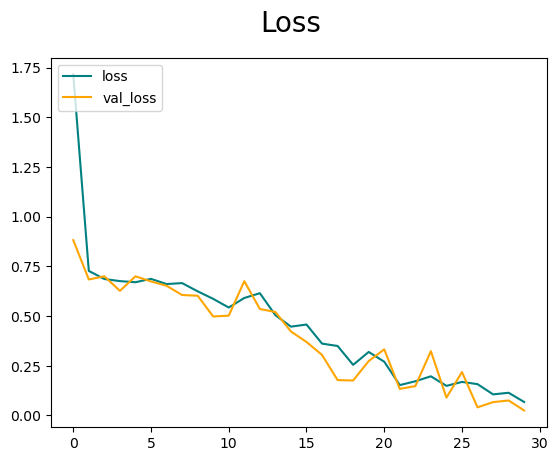

In [168]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

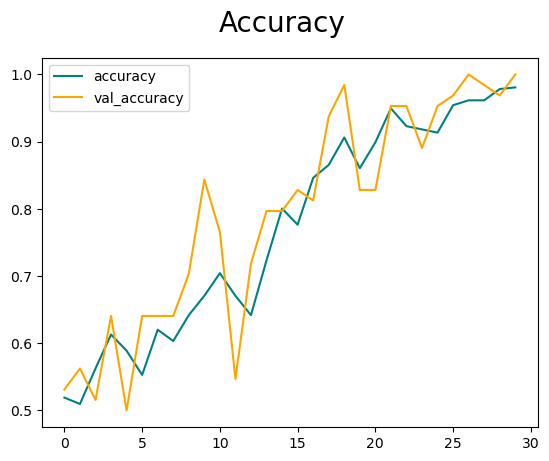

In [170]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 推論

In [2]:
import os
import tensorflow as tf
from keras.models import Sequential, Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense
from keras.utils import to_categorical
import cv2
import imghdr # 可根據文件的內容推測其類型
import matplotlib.pyplot as plt
import numpy as np

In [3]:
temp_model = load_model(os.path.join('models', 'cat_dog_classification.h5'))

In [12]:
temp_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_74 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 conv2d_75 (Conv2D)          (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 128, 128, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_76 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 conv2d_77 (Conv2D)          (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 64, 64, 128)       0         
 ng2D)                                               

(256, 256, 3)


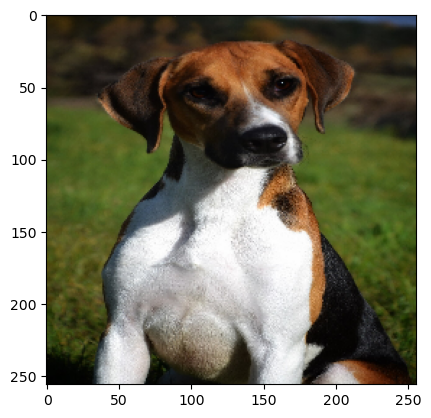

In [6]:
img = cv2.imread(os.path.join('test_data', 'dog01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
resize_img = tf.image.resize(img_rgb, (256, 256))
print(resize_img.shape)
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [7]:
y_pred = temp_model.predict(np.expand_dims(resize_img / 255, 0))
y_pred # 狗 [[0., 1.]], 貓 [[1., 0.]] 

1/1 [==============================] - 0s 151ms/step


array([[0., 1.]], dtype=float32)

In [8]:
label = np.argmax(y_pred)
if label == 0:
    print('貓')
else:
    print('狗')

狗


(256, 256, 3)


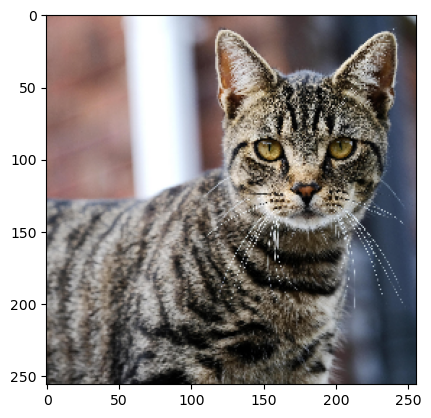

In [9]:
img = cv2.imread(os.path.join('test_data', 'cat01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
resize_img = tf.image.resize(img_rgb, (256, 256))
print(resize_img.shape)
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [10]:
y_pred = temp_model.predict(np.expand_dims(resize_img / 255, 0))
y_pred # 狗 [[0., 1.]], 貓 [[1., 0.]] 

1/1 [==============================] - 0s 50ms/step


array([[1.0000000e+00, 1.1228763e-24]], dtype=float32)

In [11]:
label = np.argmax(y_pred)
if label == 0:
    print('貓')
else:
    print('狗')

貓


# Grad-CAM

## 貓 寫法A

(256, 256, 3)
(1, 256, 256, 3)


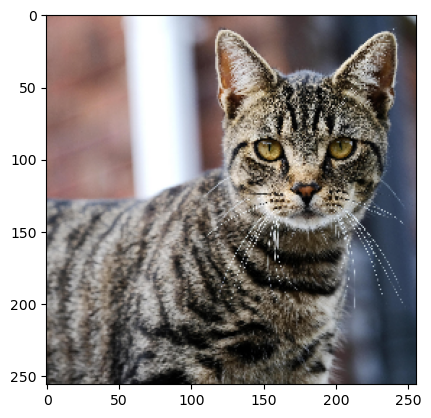

In [38]:
# 加載測試圖像，你可以替換成你自己的圖像
img = cv2.imread(os.path.join('test_data', 'cat01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
resize_img = tf.image.resize(img_rgb, (256, 256))
img = np.expand_dims(resize_img / 255, 0)  # 將圖像轉換為模型期望的形狀
print(resize_img.shape)
print(img.shape)
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [31]:
last_conv_layer = temp_model.get_layer("conv2d_79")
last_conv_layer_model = Model(temp_model.inputs, last_conv_layer.output)

In [33]:
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ["up_sampling2d_10", "flatten_2", "dense_1"]:
    x = temp_model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

In [39]:
with tf.GradientTape() as tape:
    inputs = img
    last_conv_layer_output = last_conv_layer_model(inputs)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

In [40]:
grads = tape.gradient(top_class_channel, last_conv_layer_output)

In [41]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [42]:
last_conv_layer_output = last_conv_layer_output.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

In [43]:
# Average over all the filters to get a single 2D array
gradcam = np.mean(last_conv_layer_output, axis=-1)
# Clip the values (equivalent to applying ReLU)
# and then normalise the values
gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
gradcam = cv2.resize(gradcam, (256, 256))

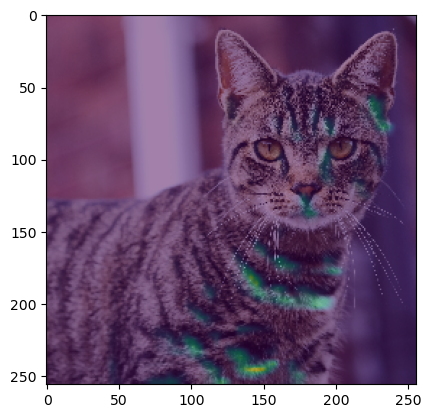

In [47]:
plt.imshow(resize_img.numpy().astype(int))
plt.imshow(gradcam, alpha=0.5)

---

## 狗 寫法B

(256, 256, 3)
(1, 256, 256, 3)


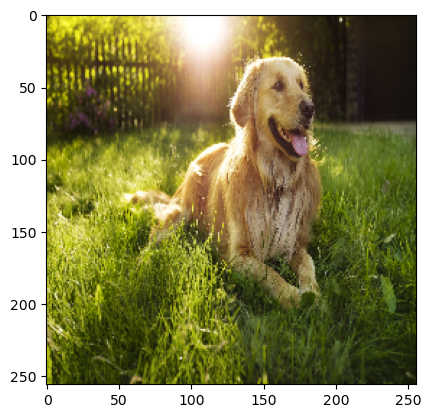

In [16]:
# 加載測試圖像，你可以替換成你自己的圖像
img = cv2.imread(os.path.join('test_data', 'dog03.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
resize_img = tf.image.resize(img_rgb, (256, 256))
img = np.expand_dims(resize_img / 255, 0)  # 將圖像轉換為模型期望的形狀
print(resize_img.shape)
print(img.shape)
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [13]:
# 創建一個模型，包括原始模型的所有層
# 這個新模型將用於生成Grad-CAM熱圖
# 取得最後一層卷積層
grad_model = Model([temp_model.inputs], [temp_model.output, temp_model.get_layer('conv2d_79').output])

In [18]:
y_pred = temp_model.predict(img)
y_pred # 狗 [[0., 1.]], 貓 [[1., 0.]] 

1/1 [==============================] - 0s 52ms/step


array([[1.4253034e-06, 9.9999857e-01]], dtype=float32)

In [19]:
label = np.argmax(y_pred)
if label == 0:
    print('貓')
else:
    print('狗')

狗


In [298]:
# # 計算梯度
# with tf.GradientTape() as tape:
#     last_conv_layer_output, model_output = grad_model(img)
#     class_output = model_output[:, class_idx]
#     grads = tape.gradient(class_output, last_conv_layer_output)

In [25]:
# 計算梯度
with tf.GradientTape() as tape:
    predictions, last_conv_layer_output = grad_model(img)
    predicted_class = tf.argmax(predictions[0])
    grads = tape.gradient(predictions[:, predicted_class], last_conv_layer_output)

tf.Tensor([0.99999857], shape=(1,), dtype=float32)


In [27]:
# 進行全局平均池化，獲取每個通道的權重
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [554]:
# 將權重乘以特徵圖的輸出，獲得特徵圖的Grad-CAM權重
last_conv_layer_output = last_conv_layer_output[0]
heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis] # 矩陣乘法
print(heatmap.shape)
heatmap = tf.squeeze(heatmap)
print(heatmap.shape)

(64, 64, 1)
(64, 64)


In [555]:
# 對熱圖進行後處理，使其可視化
heatmap = tf.maximum(heatmap, 0)  # 移除負數值
heatmap /= tf.reduce_max(heatmap)  # 正規化
heatmap = heatmap.numpy()

In [556]:
# 使用OpenCV將熱圖映射到原始圖像
img = cv2.imread(os.path.join('test_data', 'dog03.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將顏色通道從 BGR 轉換為 RGB
# resize_img = tf.image.resize(img_rgb, (256, 256))
resize_img = cv2.resize(img_rgb, (256, 256))
print(resize_img.shape)
print(img.shape)
# plt.imshow(resize_img.numpy().astype(int))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)

(256, 256, 3)
(3264, 4896, 3)


In [557]:
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

In [558]:
superimposed_img.shape

(3264, 4896, 3)

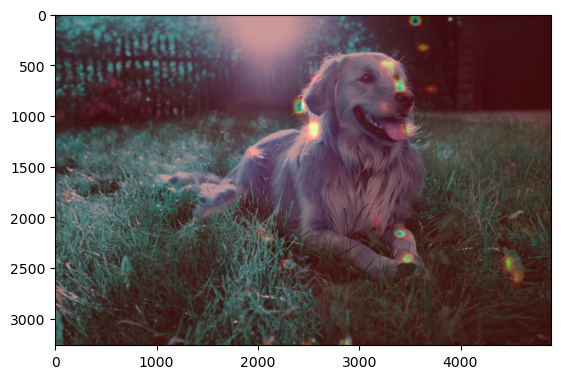

In [559]:
plt.imshow(superimposed_img)
plt.show()

In [483]:
# 保存Grad-CAM可視化結果
cv2.imwrite('grad_cam_dog02.jpg', superimposed_img)

True